# Understanding ResNet Training Performance

## Introduction
This notebook analyzes performance bottlenecks in ResNet training by measuring:
- Data loading time from disk
- GPU transfer time 
- Training (forward/backward pass) time

We'll experiment with different numbers of workers to understand their impact on performance.

In [1]:
# Imports
import torch
from torchvision import transforms, models
from datasets import load_dataset
import time
import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(710)
np.random.seed(710)

## Setup
### Load and prepare dataset

In [2]:
# Load TinyImageNet dataset
tiny_imagenet = load_dataset("Maysee/tiny-imagenet", split="train")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create PyTorch dataset wrapper
class TinyImageNet(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]["image"], self.dataset[idx]["label"]
        x = x.convert("RGB")
        if self.transform:
            x = self.transform(x)
        y = torch.tensor(y, dtype=torch.int64)
        return x, y

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset instance
tiny_imagenet_torch = TinyImageNet(tiny_imagenet, transform=transform)

### Define timing utilities

In [3]:
def time_load_transfer_train(data_loader, num_batches, model, optimizer, rolling_window=20):
    """Measure data loading, GPU transfer and training times"""
    data_load_times = []
    gpu_transfer_times = []
    forward_backward_times = []
    total_times = []

    data_load_start_time = time.time()
    for i, (x, y) in enumerate(data_loader):
        # Measure data loading time
        data_load_end_time = time.time()
        data_load_time = data_load_end_time - data_load_start_time
        data_load_times.append(data_load_time)
            
        # Measure GPU transfer time
        gpu_transfer_start_time = time.time()
        x = x.to(device)
        y = y.to(device)
        gpu_transfer_time = time.time() - gpu_transfer_start_time
        gpu_transfer_times.append(gpu_transfer_time)
        
        # Measure training time
        optimizer.zero_grad()
        forward_backward_start_time = time.time()
        y_hat = model(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()
        forward_backward_time = time.time() - forward_backward_start_time
        forward_backward_times.append(forward_backward_time)

        if i > 0:
            total_times.append(data_load_time + gpu_transfer_time + forward_backward_time)

        data_load_start_time = time.time()
        if i == num_batches:
            break

    # Apply rolling average
    for times in [data_load_times, gpu_transfer_times, forward_backward_times, total_times]:
        times = np.convolve(times, np.ones(rolling_window)/rolling_window, mode='valid')

    return {
        "data_load_mean": np.round(np.mean(data_load_times), 2),
        "gpu_transfer_mean": np.round(np.mean(gpu_transfer_times), 2),
        "forward_backward_mean": np.round(np.mean(forward_backward_times), 2),
        "data_load_times": data_load_times,
        "gpu_transfer_times": gpu_transfer_times,
        "forward_backward_times": forward_backward_times,
        "total_times": total_times
    }

## Performance Analysis 
### Compare effect of number of workers

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


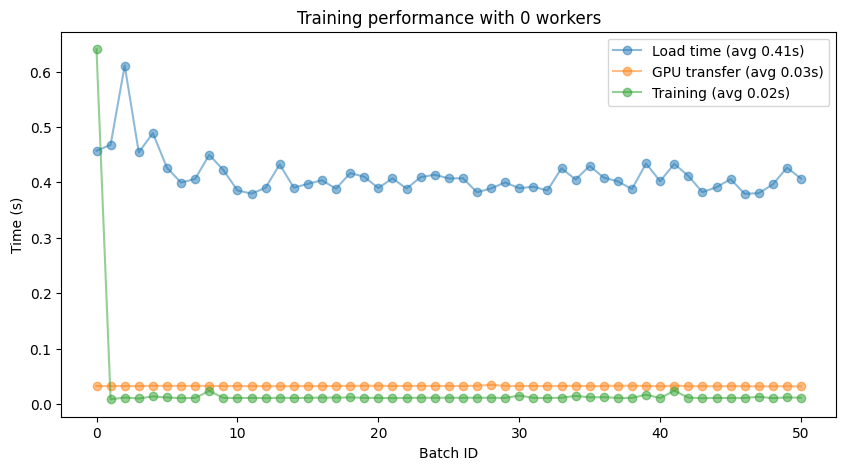

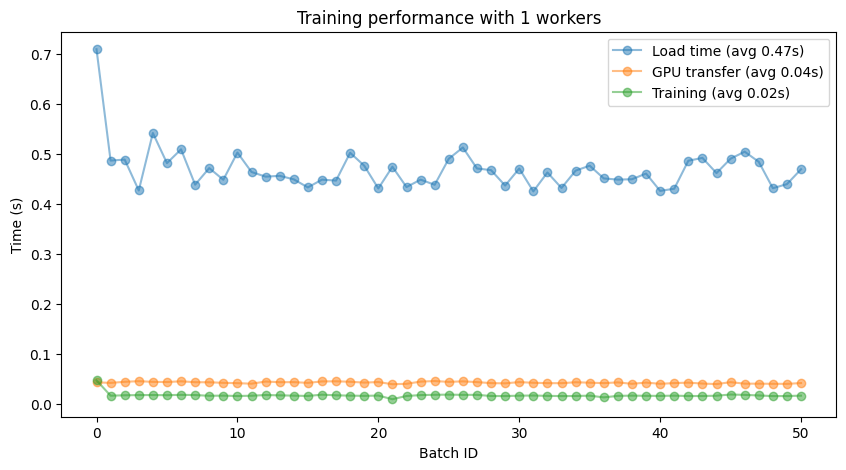

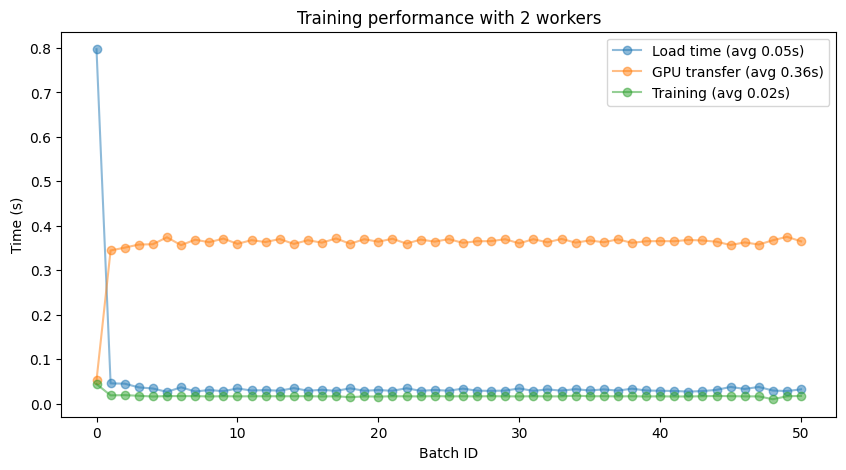

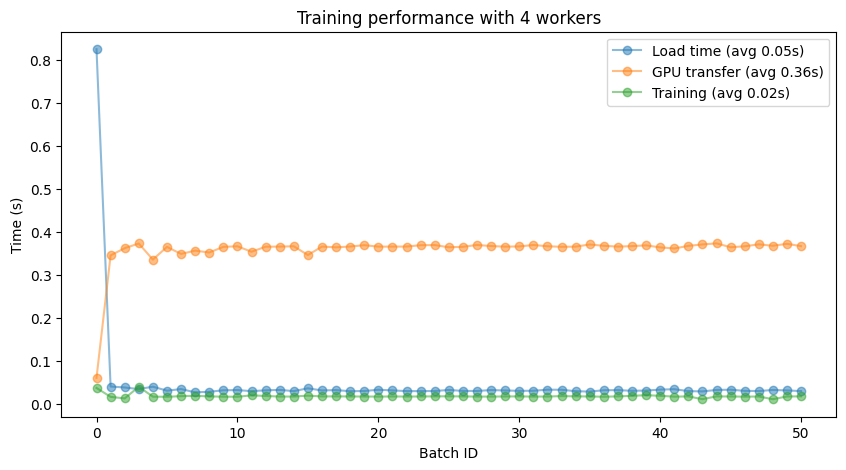

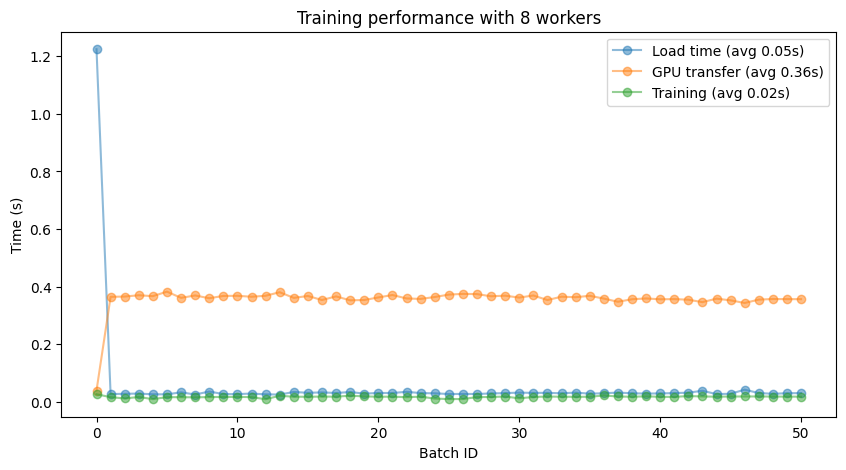

In [4]:
num_batches = 50
batch_size = 256
batch_ids = None

for num_workers in [0, 1, 2, 4, 8]:
    # Initialize model and optimizer
    model = models.resnet18(pretrained=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    # Create data loader
    data_loader = torch.utils.data.DataLoader(
        tiny_imagenet_torch, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # Time the operations
    results = time_load_transfer_train(data_loader, num_batches, model, optimizer)
    
    if batch_ids is None:
        batch_ids = np.arange(len(results['data_load_times']))
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(batch_ids, results['data_load_times'], 
             label=f"Load time (avg {results['data_load_mean']}s)", marker="o", alpha=0.5)
    plt.plot(batch_ids, results['gpu_transfer_times'],
             label=f"GPU transfer (avg {results['gpu_transfer_mean']}s)", marker="o", alpha=0.5)
    plt.plot(batch_ids, results['forward_backward_times'],
             label=f"Training (avg {results['forward_backward_mean']}s)", marker="o", alpha=0.5)

    plt.xlabel("Batch ID")
    plt.ylabel("Time (s)")
    plt.title(f"Training performance with {num_workers} workers")
    plt.legend()
    plt.show()

    # Clear memory
    del data_loader, model, optimizer
    torch.cuda.empty_cache()
    time.sleep(5)

## Conclusions

From our experiments, we found:

1. **Data Loading**: Increasing the number of workers significantly reduces data loading time

2. **GPU Transfer**: This is the main bottleneck in the training pipeline. Using larger batch sizes can help minimize the total number of transfers needed.

3. **Training Time**: Forward/backward pass times remain relatively constant regardless of the number of workers.